**CS_547 HW5**  
**Group 37**  
**Yue Cui**  
**Gaoyu Liu**   

Colab:  
https://colab.research.google.com/github/052D/CS547_SP2021/blob/main/HW5/CS547_HW5_Group37.ipynb?authuser=1

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 360

# Load Data

In [2]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pd.read_csv(loc,**kwargs)
    return out

In [1]:
fname = ("HW5_data.csv",
         "https://drive.google.com/file/d/1uvggKH43_gMdnAl8_AizPkQfqHkSFP7P/view?usp=sharing")

data_raw = getfile(fname,
                   index_col=0,
                   header=0,
                   #names = ['X', 'Y', 'Z'],
                   )
data_raw.columns = data_raw.columns.astype(str)
display(data_raw.head())



NameError: name 'getfile' is not defined

# Split Data

Since the `sklearn.model_selection.train_test_split` function only splits the data set into two portions in one function run, we need to apply this function **twice** to obtain the **training, validation, and testing** data set. We did not shuffle the raw data before spliting nor use random splitting.  

The procedure is as follows:  

1 - Split the raw data into training & validation set and testing set with a ratio of **0.8:0.2**. 

2 - Split the **training & validation set** into training set and validation set with a ratio of **0.75:0.25**. 



In [4]:
from sklearn.model_selection import train_test_split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train_validation, X_test, y_train_validation, y_test = \
    train_test_split(data_raw.loc[:, ['X', 'Y']], data_raw.Z,
                     train_size=0.8,
                     #random_state=4,
                     shuffle=False,
                     )

In [5]:
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_train_validation, y_train_validation,
                     train_size=0.75,
                     #random_state=4,
                     shuffle=False,
                     )

## Visualization

In [6]:
color_train="red"
color_validate="blue"
color_test="forestgreen"

### X-Y Plane

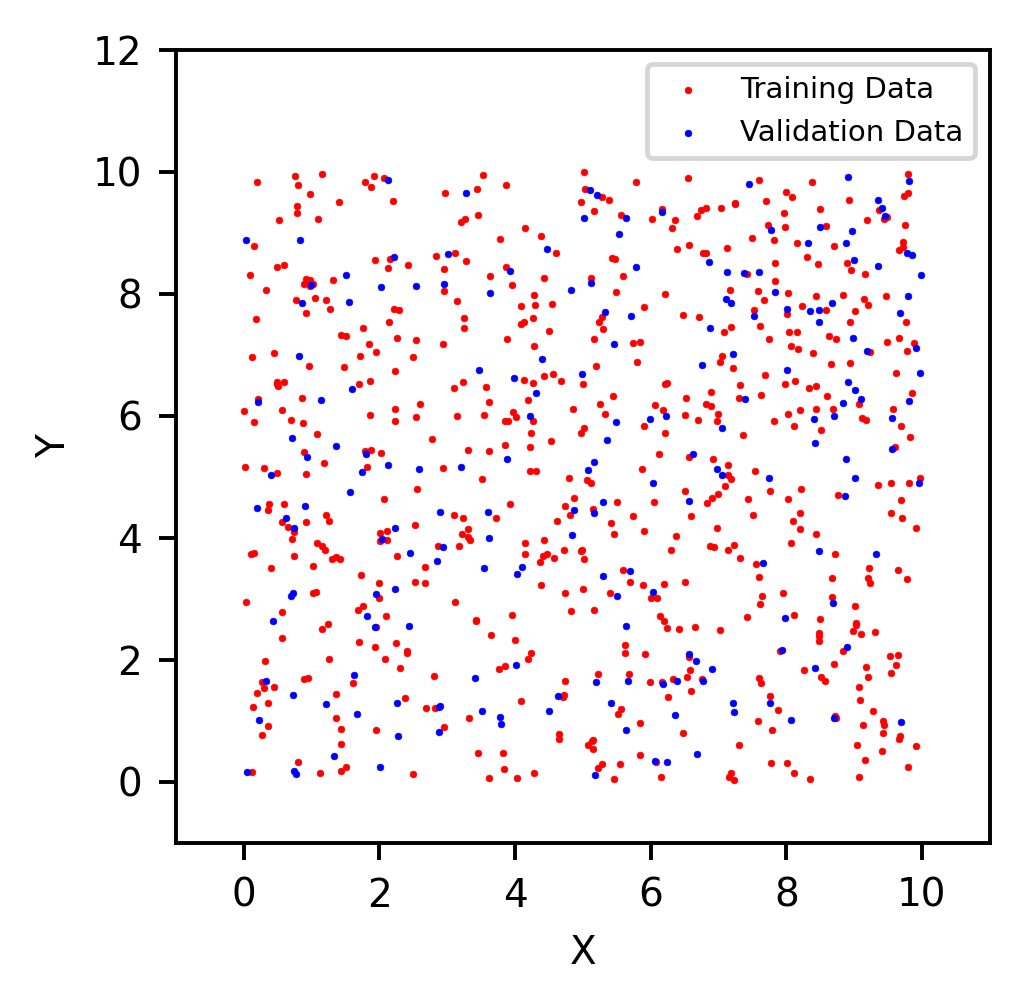

In [7]:
fig = plt.figure(figsize=(3, 3),
                 dpi=350,)
ax = fig.add_subplot(111)

ax.scatter(X_train.X, X_train.Y,
           color=color_train,
           label='Training Data',
           lw=.1,
           s=2,)

ax.scatter(X_validation.X, X_validation.Y,
           color=color_validate,
           label='Validation Data',
           lw=.1,
           s=2,)

ax.set_xlabel('X', fontsize=8)
ax.set_ylabel('Y', fontsize=8)
ax.set_xlim((-1, 11))
ax.set_ylim((-1, 12))
ax.legend(fontsize=6)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.show()

### 3D Plot

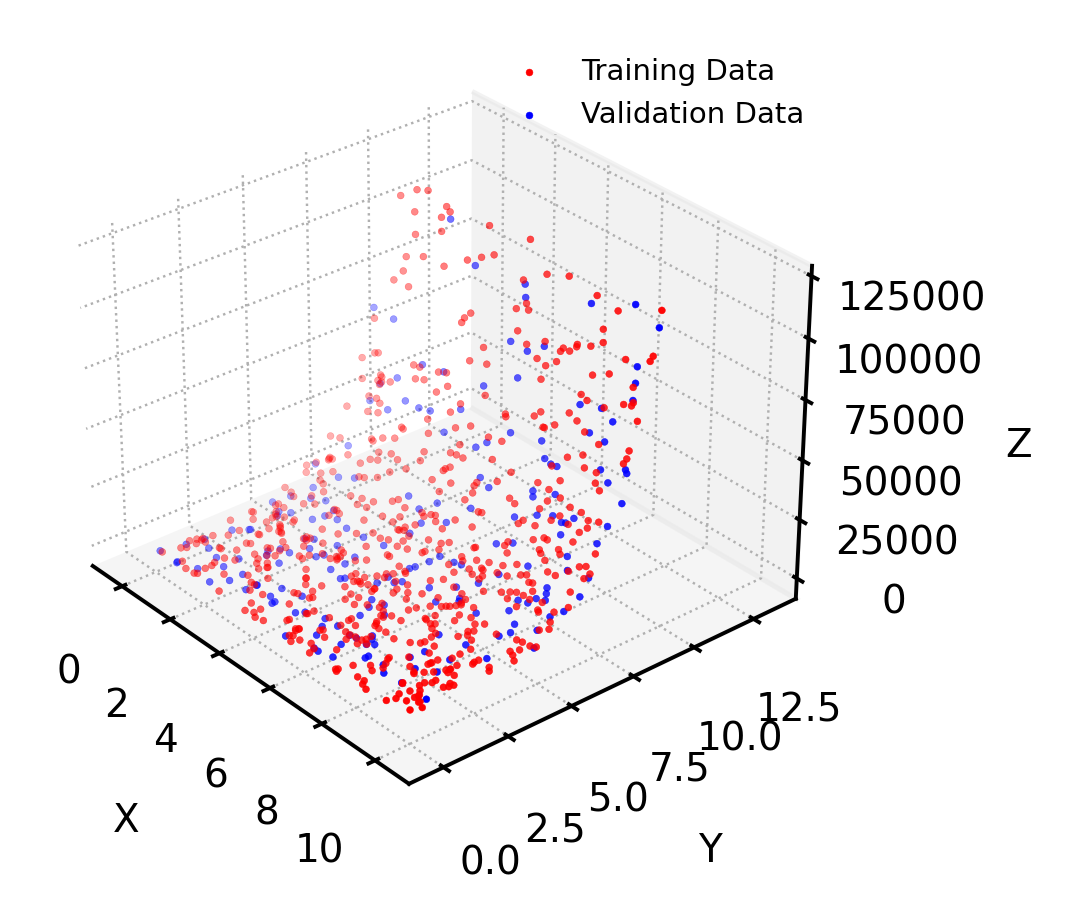

In [8]:
fig = plt.figure(figsize=(3, 3),
                 dpi=350)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train.X, X_train.Y, y_train,
           color=color_train,
           label='Training Data',
           lw=.1,
           s=2,)

ax.scatter(X_validation.X, X_validation.Y, y_validation,
           color=color_validate,
           label='Validation Data',
           lw=.1,
           s=2)

ax.set_xlabel('X', fontsize=8)
ax.set_ylabel('Y', fontsize=8)
ax.set_zlabel('Z', fontsize=8)
ax.set_xlim((-1, 11))
ax.set_ylim((-1, 14))
ax.legend(fontsize=6, loc='best', borderpad=0.3,
         frameon = False,)
#ax.legend().set_linewidth(.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
ax.w_xaxis.set_pane_color((1, 1, 1, .1))
ax.xaxis._axinfo["grid"]['linewidth'] = .5
ax.yaxis._axinfo["grid"]['linewidth'] = .5
ax.zaxis._axinfo["grid"]['linewidth'] = .5
ax.xaxis._axinfo["grid"]['linestyle'] = ":"
ax.yaxis._axinfo["grid"]['linestyle'] = ":"
ax.zaxis._axinfo["grid"]['linestyle'] = ":"

# https://stackoverflow.com/questions/41923161/changing-grid-line-thickness-in-3d-surface-plot-in-python-matplotlib

ax.view_init(30, -40)
plt.draw()
# plt.pause(.001)
plt.show()

# Polynomial Features

To consider all cases of  
$$
Z_n = \sum_{\alpha, \beta} c_{\alpha, \beta} X_n^{\alpha} Y_n^{\beta} 
$$
where  
$$
\alpha \ge 0, \ \beta \ge 0
$$

we use `sklearn.preprocessing.PolynomialFeatures` to generate all the polynomial features that meet the definition above. Intercept is **not** considered at this step.

In [9]:
from sklearn.preprocessing import PolynomialFeatures
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

D = [2, 3, 4, 5, 6, 7]
X_train_list = []
X_validation_list = []
X_test_list = []

for d in D:
    poly = PolynomialFeatures(degree=d,
                              include_bias=False,
                              )
    #
    X_train_list.append(poly.fit_transform(X_train))
    X_validation_list.append(poly.fit_transform(X_validation))
    X_test_list.append(poly.fit_transform(X_test))

del d

# Fit Linear Regression Model

Although the intercept term was not generated in the polynomial features, the intercept is considered when a linear regression model is fit using `sklearn.linear_model.LinearRegression`. 

The mean squares error (MSE) is computed using `sklearn.metrics.mean_squared_error`.

In [10]:
from sklearn.linear_model import LinearRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.metrics import mean_squared_error
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

model_list = []
MSE_list = []
y_pred_vali_list = []

for i, X_ in enumerate(X_train_list):
    reg = LinearRegression(fit_intercept=True).fit(X_, y_train)
    model_list.append(reg)
    y_pred = reg.predict(X_validation_list[i])
    y_pred_vali_list.append(y_pred)
    MSE_list.append(mean_squared_error(y_pred, y_validation))

del reg, y_pred

print(f'The MSE for the validation data for each D is :')
display(MSE_list)

The MSE for the validation data for each D is :


[36271714.89597634,
 2180085.927675116,
 21960.615275848562,
 0.010731902649748003,
 0.011034240519792507,
 0.011127754865817085]

Find the best D among the candidates.

In [11]:
best_D_idx = np.array(MSE_list).argmin()
best_D = D[best_D_idx]

print(f'The best D that minimizes the MSE for the validation data is {best_D}.')

The best D that minimizes the MSE for the validation data is 5.


# Testing MSE

In [12]:
y_pred_test = model_list[best_D_idx].predict(X_test_list[best_D_idx])
MSE_test = mean_squared_error(y_pred_test, y_test)

In [13]:
MSE_test

0.010544438312310387

# Conclusions

## Best D

In [14]:
print(f'The best D that minimizes the MSE for the validation data is {best_D}.')

The best D that minimizes the MSE for the validation data is 5.


## MSEs

In [15]:
y_pred_train = model_list[best_D_idx].predict(X_train_list[best_D_idx])
MSE_train = mean_squared_error(y_pred_train, y_train)

print(f'The MSE for the training data associated with the best D {best_D} is {MSE_train}.')
print(f'The MSE for the validation data associated with the best D {best_D} is {MSE_list[best_D_idx]}.')
print(f'The MSE for the test data associated with the best D {best_D} is {MSE_test}.')

The MSE for the training data associated with the best D 5 is 0.008270412119058674.
The MSE for the validation data associated with the best D 5 is 0.010731902649748003.
The MSE for the test data associated with the best D 5 is 0.010544438312310387.


## Coefficients

In [16]:
model_list[best_D_idx].coef_

array([ 8.62706308e-01,  9.25346591e-01,  2.70539344e-01, -2.96455711e+00,
        2.01698867e-02, -1.67192295e-02,  4.93639101e-01, -6.24851806e-03,
       -3.15132279e-03,  3.01865573e-01,  1.86021119e-04,  9.04537822e-04,
        4.52142630e-04,  2.70267580e-04, -7.87628076e-05,  2.49538014e-05,
       -6.88331528e-05,  8.92071001e-06, -2.92611205e-05,  1.19999256e+00])

In [17]:
model_list[best_D_idx].intercept_

5.124253379450238

## Visualization

### Ground Truth vs Prediction

In [18]:
# generate the mesh grid
x_mesh, y_mesh = np.meshgrid(np.arange(0, 11, 1.), 
                             np.arange(0, 11, 1.))

# prepare for the polynomial features
mesh_grid_input = np.stack((x_mesh.reshape((x_mesh.size,)),
                            y_mesh.reshape((y_mesh.size,))),
                           axis=1)

poly = PolynomialFeatures(degree=best_D,
                          include_bias=False,
                          )

poly_features = poly.fit_transform(mesh_grid_input)

mesh_grid_pred_test = model_list[best_D_idx].predict(poly_features)

z_mesh = mesh_grid_pred_test.reshape((x_mesh.shape[0], -1))



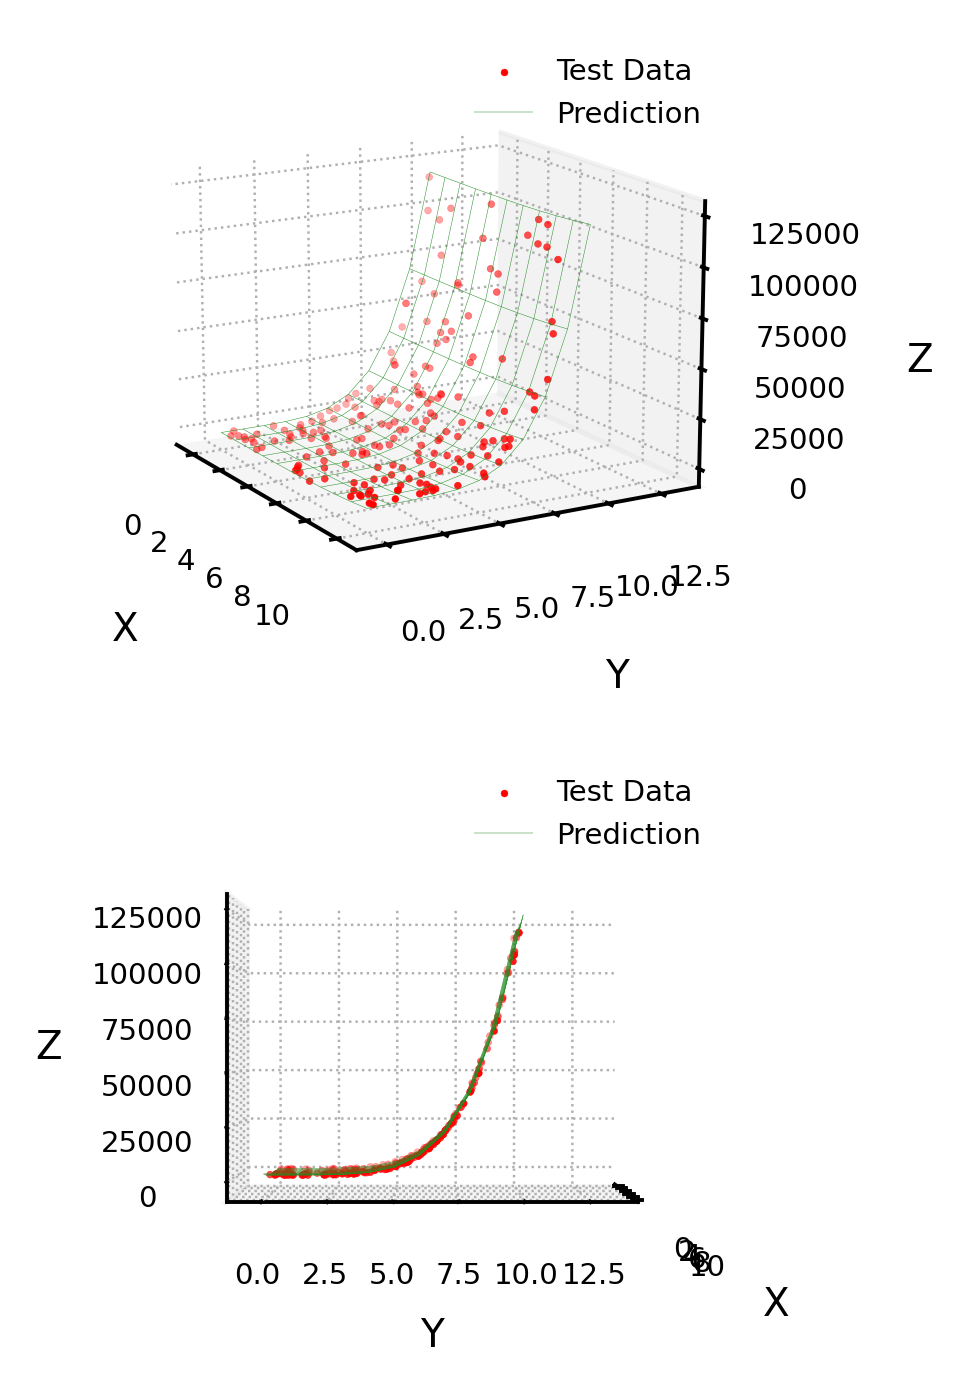

In [19]:
fig = plt.figure(figsize=(10, 5),
                 dpi=350)
ax = fig.add_subplot(2,1,1, projection='3d')

ax.scatter(X_test.X, X_test.Y, y_test,
           color=color_train,
           label='Test Data',
           lw=.1,
           s=2,)

# ax.scatter(X_test.X, X_test.Y, y_pred_test,
#            color=color_test,
#            label='Prediction',
#            lw=.1,
#            s=2,)

ax.plot_wireframe(x_mesh,
                  y_mesh,
                  z_mesh,
                  color=color_test,
                  lw = .1,
                  label = 'Prediction',
                  )

ax.set_xlabel('X', fontsize=8)
ax.set_ylabel('Y', fontsize=8)
ax.set_zlabel('Z', fontsize=8)
ax.set_xlim((-1, 11))
ax.set_ylim((-1, 14))
ax.legend(fontsize=6, loc='best', borderpad=0.3,
          frameon=False,)
# ax.legend().set_linewidth(.5)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='z', labelsize=6)
ax.w_xaxis.set_pane_color((1, 1, 1, .1))
ax.xaxis._axinfo["grid"]['linewidth'] = .5
ax.yaxis._axinfo["grid"]['linewidth'] = .5
ax.zaxis._axinfo["grid"]['linewidth'] = .5
ax.xaxis._axinfo["grid"]['linestyle'] = ":"
ax.yaxis._axinfo["grid"]['linestyle'] = ":"
ax.zaxis._axinfo["grid"]['linestyle'] = ":"

# https://stackoverflow.com/questions/41923161/changing-grid-line-thickness-in-3d-surface-plot-in-python-matplotlib

ax.view_init(15, -30)
plt.draw()



ax = fig.add_subplot(2,1,2, projection='3d')

ax.scatter(X_test.X, X_test.Y, y_test,
           color=color_train,
           label='Test Data',
           lw=.1,
           s=2,)

# ax.scatter(X_test.X, X_test.Y, y_pred_test,
#            color=color_test,
#            label='Prediction',
#            lw=.1,
#            s=2,)

ax.plot_wireframe(x_mesh,
                  y_mesh,
                  z_mesh,
                  color=color_test,
                  lw = .1,
                  label = 'Prediction',
                  )

ax.set_xlabel('X', fontsize=8)
ax.set_ylabel('Y', fontsize=8)
ax.set_zlabel('Z', fontsize=8)
ax.set_xlim((-1, 11))
ax.set_ylim((-1, 14))
ax.legend(fontsize=6, loc='best', borderpad=0.3,
          frameon=False,)
# ax.legend().set_linewidth(.5)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='z', labelsize=6)
ax.w_xaxis.set_pane_color((1, 1, 1, .1))
ax.xaxis._axinfo["grid"]['linewidth'] = .5
ax.yaxis._axinfo["grid"]['linewidth'] = .5
ax.zaxis._axinfo["grid"]['linewidth'] = .5
ax.xaxis._axinfo["grid"]['linestyle'] = ":"
ax.yaxis._axinfo["grid"]['linestyle'] = ":"
ax.zaxis._axinfo["grid"]['linestyle'] = ":"

# https://stackoverflow.com/questions/41923161/changing-grid-line-thickness-in-3d-surface-plot-in-python-matplotlib

ax.view_init(0, -0)
plt.draw()




# plt.pause(.001)
plt.show()



### Errors

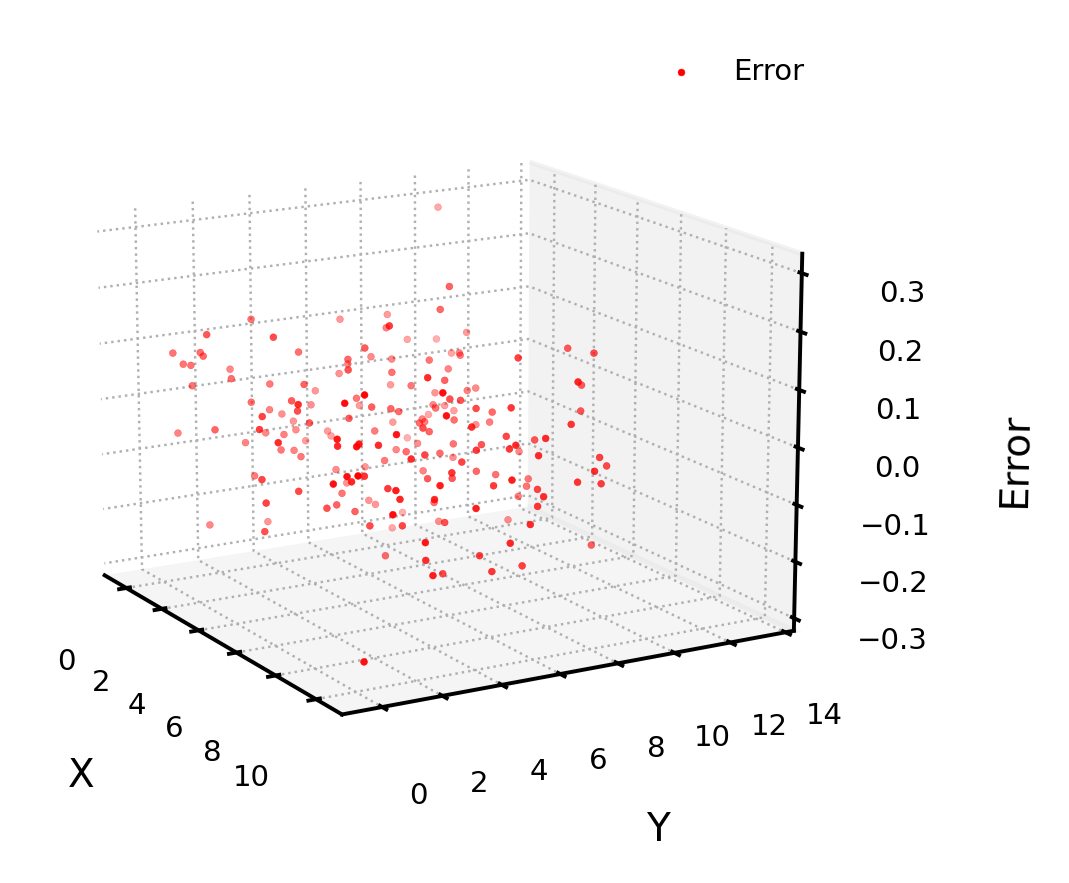

In [20]:
fig = plt.figure(figsize=(3, 3),
                 dpi=350)
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(X_test.X, X_test.Y, y_pred_test - y_test,
           color=color_train,
           label='Error',
           lw=.1,
           s=2,)


ax.set_xlabel('X', fontsize=8)
ax.set_ylabel('Y', fontsize=8)
ax.set_zlabel('Error', fontsize=8)
ax.set_xlim((-1, 11))
ax.set_ylim((-1, 14))
ax.legend(fontsize=6, loc='best', borderpad=0.3,
          frameon=False,)
# ax.legend().set_linewidth(.5)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='z', labelsize=6)
ax.w_xaxis.set_pane_color((1, 1, 1, .1))
ax.xaxis._axinfo["grid"]['linewidth'] = .5
ax.yaxis._axinfo["grid"]['linewidth'] = .5
ax.zaxis._axinfo["grid"]['linewidth'] = .5
ax.xaxis._axinfo["grid"]['linestyle'] = ":"
ax.yaxis._axinfo["grid"]['linestyle'] = ":"
ax.zaxis._axinfo["grid"]['linestyle'] = ":"

# https://stackoverflow.com/questions/41923161/changing-grid-line-thickness-in-3d-surface-plot-in-python-matplotlib

ax.view_init(15, -30)
plt.draw()
plt.show()